# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [54]:
import artm

In [55]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [56]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [57]:
batch_vectorizer = artm.BatchVectorizer(data_path="lectures.txt", 
                                        data_format="vowpal_wabbit", 
                                        target_folder="batches",
                                        batch_size=100)

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [58]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]

model_artm = artm.ARTM(num_topics=T, 
                       topic_names=["sbj"+str(i) for i in range(T)], 
                       class_ids={"text":1, "author":1}, 
                       num_document_passes=1, 
                       reuse_theta=True, 
                       cache_theta=True, 
                       seed=1)

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [59]:
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)
model_artm.initialize('dictionary')

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [60]:
model_artm.scores.add(artm.TopTokensScore(name="top_words_text", num_tokens=15, class_id="text"))
model_artm.scores.add(artm.TopTokensScore(name="top_words_authors", num_tokens=15, class_id="author"))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [61]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', 
                                                            tau=1e5,
                                                            class_ids='text',
                                                            topic_names='bcg',
                                                            dictionary='dictionary'))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [62]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [63]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhiSparse', 
                                                            tau=-1e5,
                                                            class_ids='text',
                                                            topic_names=topic_names,
                                                            dictionary='dictionary'))

Выполните еще 15 проходов по коллекции.

In [64]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [215]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ', end=" ")
    tokens = model_artm.score_tracker["top_words_text"].last_tokens
    for word in tokens[topic_name]:    
        print(word, end=" ")
    print("\n" )
    tokens = model_artm.score_tracker["top_words_authors"].last_tokens
    for word in tokens[topic_name]:    
        print(word, end=" ")
    print("\n" )

sbj0:  частица взаимодействие физика кварк стандартный симметрия дмитрий элементарный нейтрино материя протон масса слабый фундаментальный бозон 

Дмитрий_Казаков Михаил_Данилов Валерий_Рубаков Сергей_Майоров Виктор_Брагута Павел_Пахлов Игорь_Волобуев Лев_Дудко Лев_Беклемишев Анатолий_Лиходед Эдуард_Боос Сергей_Троицкий Сергей_Гашков Аркадий_Цейтлин Дэвид_Гросс 

sbj1:  материал структура температура свойство вещество химический соединение поверхность давление химия применение электронный углерод металл сверхпроводимость 

Артем_Оганов Валерий_Фокин Дмитрий_Паращук Валентин_Ненайденко Владимир_Пудалов Евгений_Гудилин Валентин_Крапошин Дмитрий_Гольберг Иван_Сорокин Наталья_Берлофф Дмитрий_Клинов Владимир_Комлев Евгений_Антипов Сергей_Морозов Алексей_Кавокин 

sbj2:  политический государство политика власть царь партия положение труд правитель кризис враг ритуал средневековый сага борьба 

Кирилл_Мартынов Алексей_Юдин Александр_Филиппов Михаил_Бойцов Дина_Гусейнова Иван_Ладынин Татьяна_С

Ирина_Бёме Олег_Будницкий Вера_Мильчина Анна_Соколова Борис_Колоницкий Варвара_Веденина Александр_Каменский Людмила_Новикова Дэвид_Кайзер Михаил_Маяцкий Михаил_Бойцов Алексей_Киличенков Архат_Абжанов Пол_Грегори Марк_Харрисон 

sbj24:  язык христианский литературный филологический христианство лингвист глагол лингвистика языковой христианин английский грамматика цивилизация согласный лингвистический 

Алексей_Муравьёв Владимир_Плунгян Олег_Воскобойников Андрей_Кибрик Мария_Штейнман Олег_Лекманов Светлана_Бурлак Петр_Аркадьев Владимир_Беликов Максим_Кронгауз Нина_Сумбатова Варвара_Добровольская Ирина_Левонтина Евгений_Зуев Игорь_Исаев 

sbj25:  теория пространство описывать про теоретический описание математический матрица уравнение математика линия описываться парадокс линейный эйнштейн 

Эмиль_Ахмедов Илья_Щуров Алексей_Семихатов Андрей_Лосев Владимир_Редько Павел_Лушников Игорь_Петров Армен_Сергеев Александр_Кислов Елена_Гороховская Владимир_Каганский Александр_Филиппов Сергей_Ландо 

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [226]:
# запишите названия тем в список
sbj_topic_labels = ["Физика элементарных частиц",
                    "Химия", 
                    "Государственная политика", 
                    "Логика и восприятие", 
                    "Мозг и мышление", 
                    "Мифы древней греции", 
                    "История России", 
                    "Сакральные праздники", 
                    "Право", 
                    "Медицина", 
                    "Биология", 
                    "Информация и память", 
                    "История", 
                    "Наука", 
                    "Астрономия", 
                    "Экономика и деньги", 
                    "Психология", 
                    "Машинное обучение", 
                    "Востоковедение",
                    "Генная инженерия", 
                    "Квантовая физика", 
                    "Культура и философия", 
                    "История революции", 
                    "Война в России", 
                    "Лингвистика", 
                    "Теория относительности", 
                    "Театр", 
                    "Вселенная", 
                    "Кино"] 
topic_labels = sbj_topic_labels + ["Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [75]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 

theta = model_artm.get_theta()
phi_a = model_artm.get_phi(class_ids='author')

In [76]:
phi_a.head()

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9,...,sbj20,sbj21,sbj22,sbj23,sbj24,sbj25,sbj26,sbj27,sbj28,sbj29
Виталий_Дунин-Барковский,0.000000,0.0,0.0,0.000000,2.108366e-02,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000
Марина_Корсакова-Крейн,0.000000,0.0,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.052239,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000
Татьяна_Гусарова,0.017871,0.0,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000
Дэвид_Кларк,0.000000,0.0,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000
Кристофер_Уиншип,0.000000,0.0,0.0,0.030813,1.553290e-14,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,2.164484e-11,0.0,0.0,0.000005


In [77]:
theta.head()

,http://postnauka.ru/video/2530,http://postnauka.ru/video/25304,http://postnauka.ru/video/25307,http://postnauka.ru/video/2531,http://postnauka.ru/video/25312,http://postnauka.ru/video/25318,http://postnauka.ru/video/2532,http://postnauka.ru/video/25321,http://postnauka.ru/video/25326,http://postnauka.ru/video/2541,...,http://postnauka.ru/video/59622,http://postnauka.ru/video/59627,http://postnauka.ru/video/59632,http://postnauka.ru/video/59633,http://postnauka.ru/video/59636,http://postnauka.ru/video/59638,http://postnauka.ru/video/5990,http://postnauka.ru/video/5999,http://postnauka.ru/video/60481,http://postnauka.ru/video/60527
sbj0,0.000000e+00,0.000000e+00,4.004118e-07,0.0,1.364561e-16,0.011259,6.695396e-03,5.711302e-03,0.013360,0.000000,...,1.205901e-08,2.870805e-02,5.256595e-06,8.084040e-03,2.790664e-03,4.275217e-03,2.870691e-02,4.084173e-03,0.055638,1.475966e-13
sbj1,5.110760e-14,0.000000e+00,2.602902e-10,0.0,3.592045e-02,0.000000,5.027853e-06,0.000000e+00,0.004921,0.000000,...,1.200034e-03,3.752816e-11,7.591692e-12,1.088878e-03,0.000000e+00,4.149341e-03,0.000000e+00,3.523576e-11,0.001345,8.975240e-09
sbj2,0.000000e+00,0.000000e+00,0.000000e+00,0.0,8.639346e-11,0.041180,0.000000e+00,8.716110e-15,0.000362,0.000000,...,1.682504e-03,0.000000e+00,4.380728e-15,7.099947e-15,0.000000e+00,2.048482e-11,0.000000e+00,3.460208e-03,0.000000,0.000000e+00
sbj3,0.000000e+00,4.793154e-14,8.888763e-06,0.0,7.623083e-03,0.000000,0.000000e+00,1.838855e-02,0.017578,0.027026,...,2.389369e-03,1.565032e-02,1.335357e-15,3.336505e-03,7.910187e-03,3.341379e-08,0.000000e+00,1.002047e-02,0.001767,2.382899e-10
sbj4,0.000000e+00,6.755716e-02,6.521924e-06,0.0,5.426327e-03,0.021855,2.848577e-13,4.944748e-03,0.000003,0.000000,...,1.414570e-02,9.564455e-03,2.183696e-10,1.827407e-03,2.588854e-15,3.886013e-02,1.334597e-11,1.002990e-02,0.000000,3.131609e-02


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

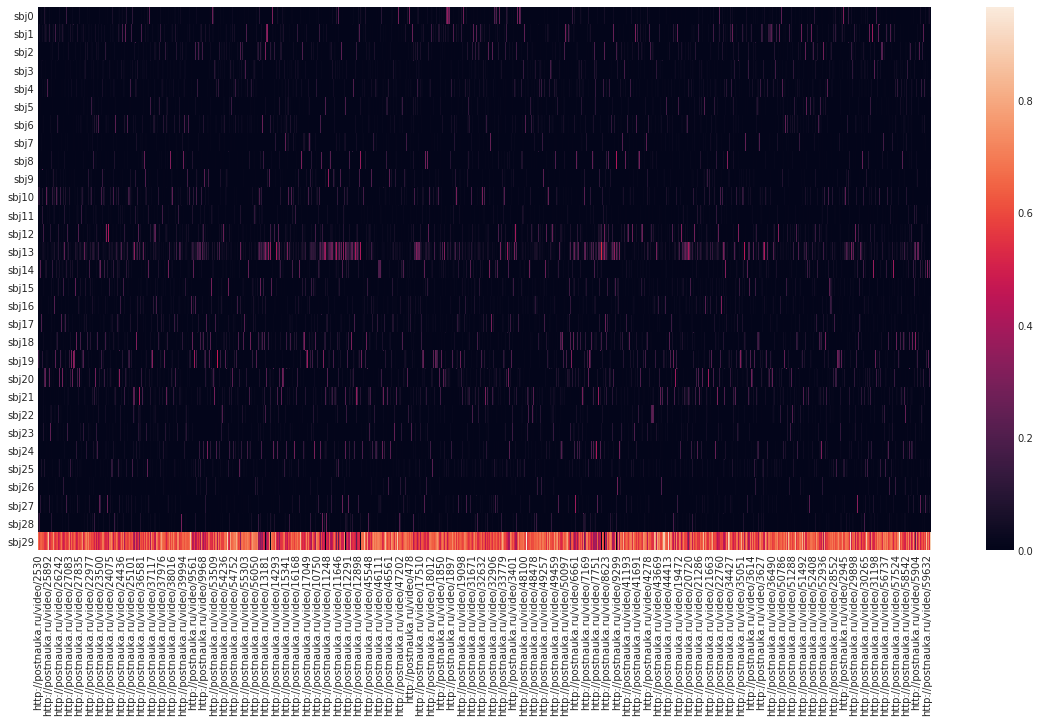

In [80]:
plt.figure(figsize = (20, 10))
ax = seaborn.heatmap(theta.head(100))

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [227]:
pt = pd.DataFrame(np.mean(theta, axis=1), columns=['pt'])
pt.index = topic_labels
pt

,pt
Физика элементарных частиц,0.012457
Химия,0.017447
Государственная политика,0.012017
Логика и восприятие,0.009371
Мозг и мышление,0.011457
Мифы древней греции,0.008310
История России,0.009577
Сакральные праздники,0.006454
Право,0.009185
Медицина,0.008618


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

In [231]:
pt.sort_values('pt')[-5:].index.tolist()

['Квантовая физика',
 'Культура и философия',
 'Генная инженерия',
 'Наука',
 'Фоновая тема']

In [232]:
pt.sort_values('pt')[:3].index.tolist()

['Театр', 'Сакральные праздники', 'Информация и память']

Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

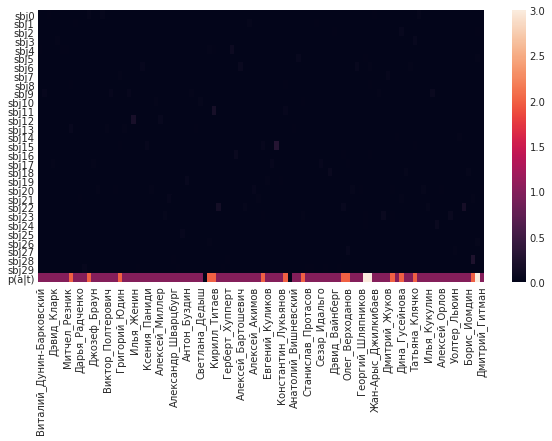

In [233]:
plt.figure(figsize = (10, 5))
ax = seaborn.heatmap(phi_a.head(100).T, yticklabels=True)

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [234]:
phi_a.head(2)

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9,...,sbj21,sbj22,sbj23,sbj24,sbj25,sbj26,sbj27,sbj28,sbj29,p(a|t)
Виталий_Дунин-Барковский,0.0,0.0,0.0,0.0,0.021084,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Марина_Корсакова-Крейн,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.052239,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [255]:
phi_a['num_t'] = np.sum(phi_a > 0.01, axis=1)
phi_a['num_t'][phi_a['num_t'] >= 3]

Олег_Ауров               3
Павел_Нерлер_(Полян)     3
Николай_Дронин           3
Михаил_Алексеевский      4
Андрей_Журавлев          3
Фёдор_Успенский          3
Александр_Тормасов       3
Мария_Фаликман           4
Ольга_Вайнштейн          4
Александр_Филиппов       3
Андрей_Чабовский         3
Александр_Пиперски       4
Ян_Левченко              4
Илья_Иткин               4
Константин_Мирошников    3
Name: num_t, dtype: int64

Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [198]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [271]:
phi_a.drop('num_t', axis=1, inplace=True)

In [298]:
pt

,pt
Физика элементарных частиц,0.012457
Химия,0.017447
Государственная политика,0.012017
Логика и восприятие,0.009371
Мозг и мышление,0.011457
Мифы древней греции,0.008310
История России,0.009577
Сакральные праздники,0.006454
Право,0.009185
Медицина,0.008618


In [299]:
authors = np.zeros_like(phi_a)

for i, row in enumerate(phi_a.values):
    authors[i] = row * pt['pt'] / sum(row * pt['pt'])

In [314]:
authors_dist = pairwise_distances(authors, metric = "cosine")

In [316]:
model = MDS(dissimilarity='precomputed', n_components=2)
mds_cos = model.fit_transform(authors_dist)

Визуализируйте найденные двумерные представления с помощью функции scatter. 

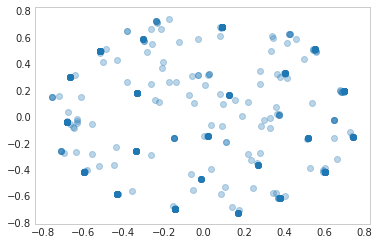

In [321]:
plt.scatter(mds_cos[:, 0], mds_cos[:, 1], alpha=0.3);

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

In [ ]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код


##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [ ]:
# Ваш код


Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [ ]:
print "http://yandex.ru"   # получится кликабельная ссылка

Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [1]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [ ]:
# Ваш код


##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 